# BigQuery Data + Hypothesis Test

In this project, I query data with SQL from the BigQuery API. The data comes from "The Look Ecommerce" dataset, which is synthetic ecommerce data that is updated regularly.

The project will follow these steps:
   - Connect to BigQuery API
   - Query for the necessary data
   - Summarize with boxplots and tables
   - Hypothesis testing on results

In [1]:
import statistics
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import seaborn as sns
import numpy as np
import pandas as pd

## Connecting to BigQuery API

In [2]:
%load_ext google.cloud.bigquery

In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account

key_path = "bigquery-example-KEY.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id)

## Shipping Time by Distribution Center

I want to explore the shipping time of orders from different distribution centers. Do certain centers ship faster than others?

There are a couple parameters to limit this question:
  - only orders within the US
  - only orders from the last month

In [4]:
sql = """
with shipping as (
  select 
    user_id, 
    inventory_item_id, 
    timestamp_diff(delivered_at, shipped_at, HOUR) as shipping_time_hrs,
    shipped_at,
    product_distribution_center_id
  from 
    bigquery-public-data.thelook_ecommerce.order_items
    left join bigquery-public-data.thelook_ecommerce.inventory_items
    on order_items.inventory_item_id = inventory_items.id
  where
    status = 'Complete' # only orders that have completed shipping
    and timestamp_diff(current_timestamp(), shipped_at, DAY) <= 31 #only in the last month
),

customers as (
  select 
    id, state, country
  from
    bigquery-public-data.thelook_ecommerce.users
  where
    country = "United States" # only customers in the US
), 

distribution as (
  select * from bigquery-public-data.thelook_ecommerce.distribution_centers
)

select 
  product_distribution_center_id as distribution_center_id,
  name as distribution_center,
  shipping_time_hrs
from customers
  inner join 
    (shipping join distribution on shipping.product_distribution_center_id = distribution.id)
  on customers.id = shipping.user_id
;
"""
shipping = client.query(sql).to_dataframe()

In [5]:
shipping

,distribution_center_id,distribution_center,shipping_time_hrs
0,1,Memphis TN,27
1,3,Houston TX,28
2,8,Mobile AL,87
3,2,Chicago IL,33
4,2,Chicago IL,30
...,...,...,...
1348,3,Houston TX,116
1349,1,Memphis TN,88
1350,9,Charleston SC,83
1351,9,Charleston SC,75


### Summarizing Data in Boxplots

In [6]:
shipping['distribution_center'] = shipping.distribution_center.replace(
                                                        "Port Authority of New York/New Jersey NY/NJ",
                                                        value = "New York NY")

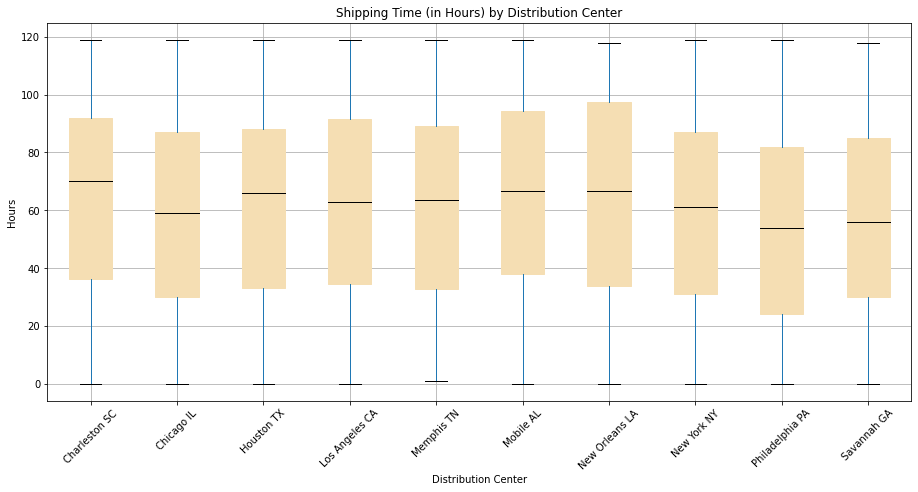

In [7]:
ax = shipping.boxplot(column='shipping_time_hrs', 
                      by="distribution_center", 
                      figsize=(15,7), rot=45,
                      patch_artist=True,
                      boxprops=dict(facecolor='wheat', color='wheat'),
                      medianprops=dict(color='k'))
ax.set_ylabel("Hours")
ax.set_xlabel("Distribution Center")
ax.set_title("Shipping Time (in Hours) by Distribution Center")
ax.get_figure().suptitle('');

### Summarizing Data in a Table

I can summarize this data in a table by two different methods to get the same results:
   1. Manipulating the data in Pandas
   2. Performing another SQL query to aggregate the results

In [8]:
# 1. Manipulating the data in Pandas
table = shipping.groupby(by=['distribution_center'])\
                        .agg(['mean', 'count'])['shipping_time_hrs']\
                        .sort_values(by=['mean'])
table['mean'] = table['mean'].apply(lambda x: round(x, 1))
table = table.rename(columns={"mean":"avg_shipping_hrs", "count":"num_orders"})
table

,avg_shipping_hrs,num_orders
distribution_center,,
Philadelphia PA,54.5,137
Savannah GA,57.3,93
Chicago IL,59.0,191
New York NY,60.0,128
Memphis TN,60.8,168
Houston TX,61.0,165
Los Angeles CA,62.3,127
New Orleans LA,63.6,88
Mobile AL,64.9,128


In [9]:
# 2. Performing another SQL query to aggregate data
sql = """
with shipping as (
  select 
    user_id, 
    inventory_item_id, 
    timestamp_diff(delivered_at, shipped_at, HOUR) as shipping_time_hrs,
    shipped_at,
    product_distribution_center_id
  from 
    bigquery-public-data.thelook_ecommerce.order_items
    left join bigquery-public-data.thelook_ecommerce.inventory_items
    on order_items.inventory_item_id = inventory_items.id
  where
    status = 'Complete' # only orders that have completed shipping
    and timestamp_diff(current_timestamp(), shipped_at, DAY) <= 31 #only in the last month
),

customers as (
  select 
    id, state, country
  from
    bigquery-public-data.thelook_ecommerce.users
  where
    country = "United States" # only customers in the US
), 

distribution as (
  select * from bigquery-public-data.thelook_ecommerce.distribution_centers
)

select 
  # product_distribution_center_id as distribution_center_id,
  name as distribution_center,
  round(avg(shipping_time_hrs),1) as avg_shipping_hrs,
  count(*) as num_orders,
from customers
  inner join 
    (shipping join distribution on shipping.product_distribution_center_id = distribution.id)
  on customers.id = shipping.user_id
group by name
order by avg_shipping_hrs
;
"""
shipping_summary = client.query(sql).to_dataframe()
shipping_summary

,distribution_center,avg_shipping_hrs,num_orders
0,Philadelphia PA,54.5,137
1,Savannah GA,57.3,93
2,Chicago IL,59.0,191
3,Port Authority of New York/New Jersey NY/NJ,60.0,128
4,Memphis TN,60.8,168
5,Houston TX,61.0,165
6,Los Angeles CA,62.3,127
7,New Orleans LA,63.6,88
8,Mobile AL,64.9,128
9,Charleston SC,65.1,128


## Hypothesis Testing

Is there a statistically significant difference between the fastest and slowest distribution centers?

In [10]:
fastest = table.index[0]
slowest = table.index[-1]

print(f'Fastest: {fastest}')
print(f'Slowest: {slowest}')

Fastest: Philadelphia PA
Slowest: Charleston SC


Defining the question:
   - Null hypothesis:
      - **The shipping times at the two distribution centers are the same.**
   - Alternative hypothesis: 
      - **The shipping times at the two distribution centers are not the same.** 

In [11]:
# separate Pandas series 
fast = shipping[shipping.distribution_center==fastest].shipping_time_hrs.astype('int64')
slow = shipping[shipping.distribution_center==slowest].shipping_time_hrs.astype('int64')

In [12]:
# "long form" dataset to be used for plotting
compare = shipping[(shipping.distribution_center==fastest)|(shipping.distribution_center==slowest)]
compare = compare.astype({'distribution_center_id':'int64', 
                            'distribution_center':'category', 
                            'shipping_time_hrs':'int64'})

### Checking Normality

I must evaluate if the data is normally distributed.

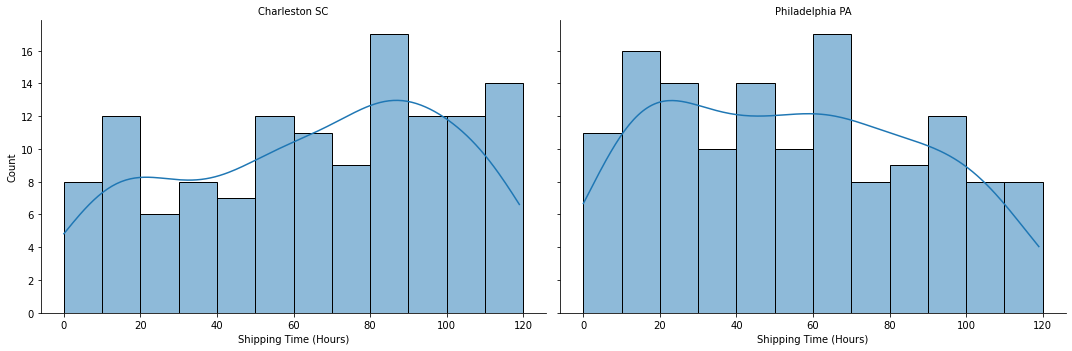

In [13]:
facet = sns.displot(data=compare, 
                    x="shipping_time_hrs", 
                    col="distribution_center", 
                    kde=True, 
                    aspect=1.5, 
                    stat='count',
                    bins = range(0,121,10))
facet.set_xlabels("Shipping Time (Hours)")
facet.set_titles("{col_name}");

In [14]:
fast_normality = shapiro(fast)
slow_normality = shapiro(slow)

print(f"Shapiro-Wilk Normality Test for {slowest} Shipping Times:")
print(f"statistic: {fast_normality[0]:.3f}")
print(f"p-value:   {fast_normality[1]:.5f}")
print()

print(f"Shapiro-Wilk Normality Test for {fastest} Shipping Times:")
print(f"statistic: {slow_normality[0]:.3f}")
print(f"p-value:   {slow_normality[1]:.5f}")

Shapiro-Wilk Normality Test for Charleston SC Shipping Times:
statistic: 0.956
p-value:   0.00023

Shapiro-Wilk Normality Test for Philadelphia PA Shipping Times:
statistic: 0.945
p-value:   0.00006


In [15]:
if fast_normality[1] > .05 and slow_normality[1] > .05:
    print(""""
Because the p-value for both of the distributions is greater than the significance level of .05
in the Shapiro-Wilk Test, we do not reject the null hypothesis that they are normally distributed.

Therefore, I will use the two sample t-test to test the hypothesis because:
   - the data can be assumed to be normally distributed
   - the two sets are independent
   """)
    test = ttest_ind
    test_name = "t-test"
else : 
    print("""
Because the p-value for one or both of the distributions is less than the significance level of .05 
in the Shapiro-Wilk Test, we can reject the null hypothesis that they are normally distributed.

Therefore, I will use the Mann Whitney U test to test the hypothesis because:
   - the data is not normally distributed
   - the two sets are independent
   """)
    test = mannwhitneyu
    test_name = "Mann Whitney U Test"


Because the p-value for one or both of the distributions is less than the significance level of .05 
in the Shapiro-Wilk Test, we can reject the null hypothesis that they are normally distributed.

Therefore, I will use the Mann Whitney U test to test the hypothesis because:
   - the data is not normally distributed
   - the two sets are independent
   


### Testing

In [16]:
results = test(fast, slow)

In [17]:
print(f"{test_name} for Shipping Times:")
print(f"statistic: {results[0]:.1f}")
print(f"p-value:   {results[1]:.5f}")
print()

Mann Whitney U Test for Shipping Times:
statistic: 7213.0
p-value:   0.01265



### Conclusions

In [18]:
if results[1]<.05:
    print(f"""
Because the p-value is < .05, the null hypothesis (that the shipping times from the two distribution centers 
are the same) is REJECTED at a 5% significance level.

That is to say: 
There IS a statistically significant difference between the shipping times from the 
{fastest} distribution center and the shipping times from the {slowest} distribution center.
    """)
else: 
    print(f""""
Because the p-value is >=.05, the null hypothesis (that the shipping times from the two distribution centers
are the same) is NOT REJECTED at a 5% signifiance level.

That is to say:
There is not a statistically significant difference between the shipping times from the 
{fastest} distribution center and the shipping times from the {slowest} distribution center.
    """)


Because the p-value is < .05, the null hypothesis (that the shipping times from the two distribution centers 
are the same) is REJECTED at a 5% significance level.

That is to say: 
There IS a statistically significant difference between the shipping times from the 
Philadelphia PA distribution center and the shipping times from the Charleston SC distribution center.
    
